(34, 34, 3)


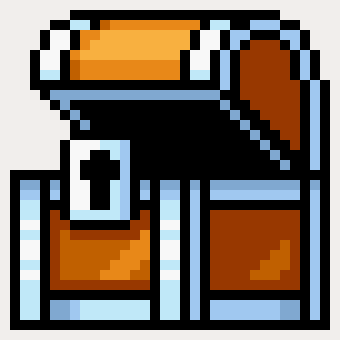

In [16]:
from PIL import Image
import numpy as np

pixels = np.array(Image.open('sma_chest_input.png'))
h, w = pixels.shape[:2]
print(pixels.shape)
Image.fromarray(pixels).resize((w * 10, h * 10), Image.NEAREST)

In [17]:
palette = list(set(tuple(x) for x in pixels.reshape(-1, 3)))
print(len(palette))
palette

10


[(128, 168, 208),
 (232, 136, 24),
 (152, 56, 0),
 (248, 248, 248),
 (0, 0, 0),
 (248, 176, 64),
 (192, 96, 0),
 (192, 232, 248),
 (241, 238, 236),
 (160, 200, 240)]

In [18]:
reverse_palette = {c:i for i, c in enumerate(palette)}
X = np.mgrid[0:h, 0:w].reshape(2, -1).T
X = X - X.mean(axis=0)
y = np.array([reverse_palette[tuple(x)] for x in pixels.reshape(-1, 3)])
X = X.astype('float32')

In [19]:
import torch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
X_tensor.shape

torch.Size([1156, 2])

In [28]:
from torch.utils.data import DataLoader, Dataset
REPEATS = 5000
class MyDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        assert len(X) == len(y)
    def __getitem__(self, index):
        i = index % self.X.size(0)
        return self.X[i], self.y[i]
    def __len__(self):
        return self.X.shape[0] * REPEATS
dataset = MyDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=X_tensor.shape[0], shuffle=False)

In [6]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 46.7 MB/s eta 0:00:00


In [46]:
import lightning as L
import torchmetrics
import torch.nn.functional as F
import torch.optim.lr_scheduler as Scheduler
import torchmetrics.classification
from lightning.pytorch.callbacks import TQDMProgressBar

class MyClassifier(L.LightningModule):
    def __init__(self, input_dim, num_classes):
        super(MyClassifier, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.fc2 = torch.nn.Linear(128, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.fc3 = torch.nn.Linear(256, 256)
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.fc4 = torch.nn.Linear(256, 512)
        self.bn4 = torch.nn.BatchNorm1d(512)
        self.fc5 = torch.nn.Linear(512, 256)
        self.bn5 = torch.nn.BatchNorm1d(256)
        self.fc6 = torch.nn.Linear(256, num_classes)
        self.accuracy = torchmetrics.classification.Accuracy(task='multiclass', num_classes=num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        accuracy = self.accuracy(logits, y)
        self.log('train_accuracy', accuracy, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-3) # 2e-3
        scheduler = Scheduler.StepLR(optimizer, step_size=5000, gamma=0.9)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}

# Initialize model
model = MyClassifier(input_dim=X.shape[1], num_classes=len(set(y)))

# Train model
pbar = TQDMProgressBar(refresh_rate=10, leave=True)
trainer = L.Trainer(max_epochs=5, callbacks=[pbar])
trainer.fit(model, dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name     | Type               | Params | Mode 
---------------------------------------------------------
0  | fc1      | Linear             | 384    | train
1  | bn1      | BatchNorm1d        | 256    | train
2  | fc2      | Linear             | 33.0 K | train
3  | bn2      | BatchNorm1d        | 512    | train
4  | fc3      | Linear             | 65.8 K | train
5  | bn3      | BatchNorm1d        | 512    | train
6  | fc4      | Linear             | 131 K  | train
7  | bn4 

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Accuracy: 1.0


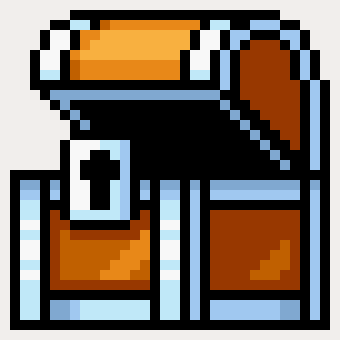

In [47]:
# Test training data
model.eval()
y_pred = model(X_tensor).argmax(dim=1)
y_pred = y_pred.detach().numpy()
print(f'Accuracy: {(y_pred == y).mean()}')
Image.fromarray(np.array(palette)[y_pred].reshape(h, w, 3)).resize((w * 10, h * 10), Image.NEAREST)

torch.Size([640000, 2])
(640000,)


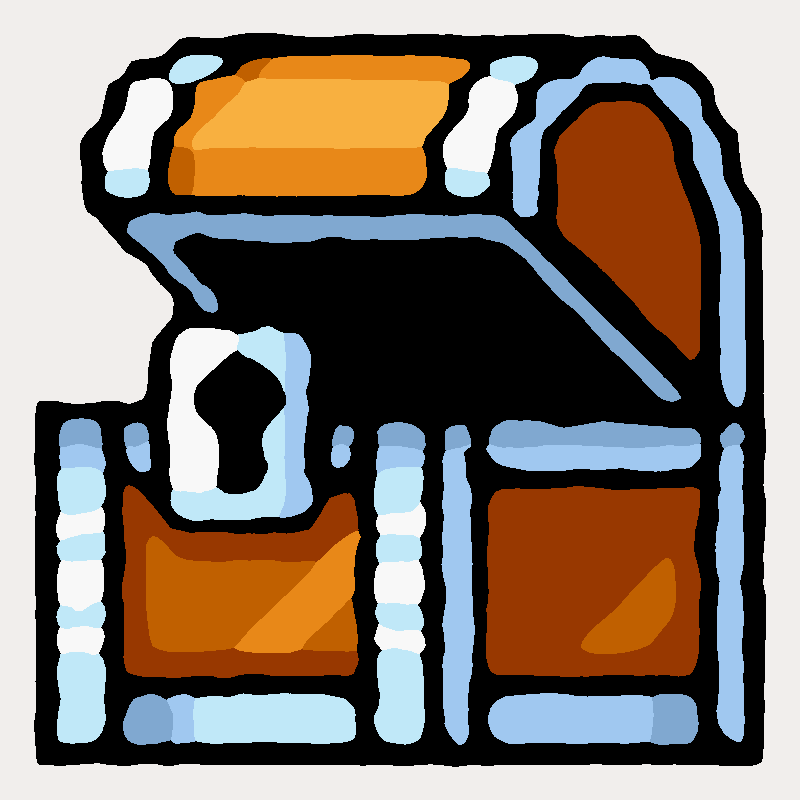

In [48]:
# Test
model.eval()
x_min, y_min = X[:, :2].min(axis=0)-1
x_max, y_max = X[:, :2].max(axis=0)+1
grid = np.mgrid[x_min:x_max:800j, y_min:y_max:800j]
# grid.shape = (2, 200, 200)
test_X = grid.reshape(2, -1).T
test_X = torch.tensor(test_X, dtype=torch.float32)
print(test_X.shape)
pred_y = model(test_X)
pred_y = pred_y.argmax(dim=1).detach().numpy()
print(pred_y.shape)
pred_y = pred_y.reshape(800,800)
Image.fromarray(np.array(palette)[pred_y].reshape(800,800,3))